# STOCK ANALYSIS AND PREDICTION AI SYSTEM

# Important Disclaimer

This project is a DEMONSTRATION of how to apply AI and traditional machine learning techniques to stock analysis. It is NOT intended for actual investment decisions. Please note:

- This is an educational project demonstrating AI/ML applications
- It does NOT provide investment advice or recommendations
- The forecasts and analyses are for demonstration purposes only
- Do NOT use this for actual investment decisions
- The developers take NO responsibility for any investment decisions made using this tool
- This project is designed to help beginners understand how AI can be applied to traditional ML problems

# Introduction

## Project Ideals
- Demonstrate practical applications of Generative AI in financial analysis
- Combine traditional financial models with modern AI capabilities
- Provide an interactive and intelligent stock analysis experience
- Showcase various AI capabilities including structured output, agents, Context Caching, Function Calling and MLOps
- Make stock analysis more accessible through natural language interaction

## AI Capabilities Demonstrated
- Structured Output/JSON Mode
- Agents
- Context Caching
- Function Calling
- MLOps(with GenAI)

## Main Components
- StockData Class
- StockModelHoldout Class
- StockHyperopt Class
- StockAgent Class

Each component is designed to work together to provide a complete stock analysis solution.

## Reference
https://github.com/brightlee6/Stock-Analysis-Forecasting-Agent


# Setup

## Uninstall and install packages

In [25]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai yfinance
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7' 'yfinance==0.2.55'

In [26]:
# check yfinance installed with right version
# !pip list | grep yfinance

## Set up your API key

The `GOOGLE_API_KEY` environment variable can be set to automatically configure the underlying API. This works for both the official Gemini Python SDK and for LangChain/LangGraph. 

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [27]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

## 1. Stock Data Management <a name="stock-data"></a>

The `StockData` class handles the fetching and management of stock price data using the yfinance library.

### Features:
- Fetch historical stock closing prices
- Save data to CSV files
- Visualize price trends and daily returns
- Handle data validation and error cases

### Dependencies:
- yfinance: For fetching stock data
- pandas: For data manipulation
- matplotlib & seaborn: For visualization

In [28]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

class StockData:
    def __init__(self, ticker, start_date, end_date):
        """
        Initialize a StockData object with ticker and date range.
        
        Args:
            ticker (str): Stock ticker symbol (e.g., 'AAPL' for Apple)
            start_date (str): Start date in 'YYYY-MM-DD' format
            end_date (str): End date in 'YYYY-MM-DD' format
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.dataframe = None
        
    def fetch_closing_prices(self):
        """
        Fetch closing prices for the stock and store in dataframe.
        """
        try:
            # Convert string dates to datetime objects
            start = datetime.strptime(self.start_date, '%Y-%m-%d')
            end = datetime.strptime(self.end_date, '%Y-%m-%d')
            
            # Fetch stock data using yf.download
            data = yf.download(self.ticker, start=start, end=end)
            
            # Extract closing prices and reset index to make Date a column
            self.dataframe = data[['Close']].reset_index()
            
            # Rename columns for clarity
            self.dataframe.columns = ['Date', 'Close']
            
            print(f"Successfully fetched closing prices for {self.ticker}")
            
        except Exception as e:
            print(f"Error occurred: {str(e)}")
            
    def save_to_csv(self, output_file):
        """
        Save the closing prices to a CSV file.
        
        Args:
            output_file (str): Path to save the CSV file
        """
        if self.dataframe is not None:
            self.dataframe.to_csv(output_file, index=False)
            print(f"Successfully saved closing prices to {output_file}")
        else:
            print("No data available. Please call fetch_closing_prices() first.")
            
    def visualize_data(self, save_path=None):
        """
        Create visualizations for the stock data.
        
        Args:
            save_path (str, optional): Path to save the visualization. If None, the plot will be displayed.
        """
        if self.dataframe is None:
            print("No data available. Please call fetch_closing_prices() first.")
            return
            
        try:
            # Set the style
            plt.style.use('seaborn-v0_8')  # Use a valid style name
            
            # Create a figure with subplots
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
            
            # Plot 1: Closing Price Over Time
            sns.lineplot(data=self.dataframe, x='Date', y='Close', ax=ax1)
            ax1.set_title(f'{self.ticker} Closing Price Over Time')
            ax1.set_xlabel('Date')
            ax1.set_ylabel('Price ($)')
            ax1.grid(True)
            
            # Calculate daily returns
            self.dataframe['Daily_Return'] = self.dataframe['Close'].pct_change()
            
            # Plot 2: Daily Returns Distribution
            sns.histplot(data=self.dataframe, x='Daily_Return', bins=50, ax=ax2)
            ax2.set_title(f'{self.ticker} Daily Returns Distribution')
            ax2.set_xlabel('Daily Return')
            ax2.set_ylabel('Frequency')
            ax2.grid(True)
            
            # Add some statistics
            mean_return = self.dataframe['Daily_Return'].mean()
            std_return = self.dataframe['Daily_Return'].std()
            ax2.axvline(mean_return, color='r', linestyle='--', label=f'Mean: {mean_return:.4f}')
            ax2.axvline(mean_return + std_return, color='g', linestyle='--', label=f'Std Dev: {std_return:.4f}')
            ax2.axvline(mean_return - std_return, color='g', linestyle='--')
            ax2.legend()
            
            plt.tight_layout()
            
            if save_path:
                plt.savefig(save_path)
                print(f"Visualization saved to {save_path}")
            else:
                plt.show()
                
            plt.close()
            
        except Exception as e:
            print(f"Error creating visualization: {str(e)}")

### Un-comment the following to run the testing for the StockData Module

In [29]:
# # Example usage and testing for the StockData module
# stock_data_test = StockData(
#         ticker='GOOG',
#         start_date='2024-01-01',
#         end_date='2025-04-19'
#     )
    
# # Fetch the closing prices
# stock_data_test.fetch_closing_prices()

# # Display
# print(stock_data_test.dataframe.head())

# # Save to CSV
# stock_data_test.save_to_csv("google_stock_prices.csv")
    
# # Create visualizations
# stock_data_test.visualize_data() 
# stock_data_test.visualize_data("google_stock_analysis.png") 

## 2. Holdout Validation Model <a name="holdout"></a>

The `StockModelHoldout` class implements a holdout validation approach for stock price forecasting using Prophet.

### Features:
- Split data into training (80%) and testing (20%) sets
- Train Prophet model on historical data
- Make predictions on test data
- Calculate performance metrics (MAE, MSE, RMSE, R²)
- Visualize actual vs predicted values

### Dependencies:
- prophet: For time series forecasting
- scikit-learn: For performance metrics
- matplotlib & seaborn: For visualization

In [30]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

class StockModelHoldout:
    def __init__(self, stock_data):
        """
        Initialize StockModelHoldout with StockData object.
        
        Args:
            stock_data (StockData): StockData object containing the stock data
        """
        if not isinstance(stock_data, StockData):
            raise ValueError("Input must be a StockData object")
            
        self.stock_data = stock_data
        self.train_data = None
        self.test_data = None
        self.model = None
        self.forecast = None
        self.metrics = None
        
    def split_data(self, test_size=0.2):
        """
        Split the data into training and testing sets.
        
        Args:
            test_size (float): Proportion of data to use for testing (default: 0.2)
        """
        if self.stock_data.dataframe is None:
            raise ValueError("No data available. Please fetch data first.")
            
        # Sort data by date
        df = self.stock_data.dataframe.sort_values('Date')
        
        # Calculate split index
        split_idx = int(len(df) * (1 - test_size))
        
        # Split the data
        self.train_data = df.iloc[:split_idx].copy()
        self.test_data = df.iloc[split_idx:].copy()
        
        # Prepare data for Prophet
        self.train_data = self.train_data.rename(columns={'Date': 'ds', 'Close': 'y'})
        self.test_data = self.test_data.rename(columns={'Date': 'ds', 'Close': 'y'})
        
    def train_model(self):
        """
        Train the Prophet model on the training data.
        """
        if self.train_data is None:
            raise ValueError("No training data available. Please split data first.")
            
        # Initialize and fit the model
        self.model = Prophet()
        self.model.fit(self.train_data)
        
    def make_forecast(self):
        """
        Make forecasts on the test data.
        """
        if self.model is None:
            raise ValueError("No trained model available. Please train the model first.")
            
        # Create future dataframe for test dates
        future = self.test_data[['ds']]
        
        # Make predictions
        self.forecast = self.model.predict(future)
        
    def calculate_metrics(self):
        """
        Calculate performance metrics for the forecast.
        """
        if self.forecast is None:
            raise ValueError("No forecast available. Please make forecast first.")
            
        # Extract actual and predicted values
        y_true = self.test_data['y'].values
        y_pred = self.forecast['yhat'].values
        
        # Calculate metrics
        self.metrics = {
            'MAE': mean_absolute_error(y_true, y_pred),
            'MSE': mean_squared_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'R2': r2_score(y_true, y_pred)
        }
        
    def visualize_forecast(self, save_path=None):
        """
        Visualize the actual vs predicted values over the test period.
        
        Args:
            save_path (str, optional): Path to save the visualization. If None, the plot will be displayed.
        """
        if self.forecast is None:
            raise ValueError("No forecast available. Please make forecast first.")
            
        try:
            # Set the style
            plt.style.use('seaborn-v0_8')
            
            # Create the plot
            plt.figure(figsize=(12, 6))
            
            # Plot actual values
            plt.plot(self.test_data['ds'], self.test_data['y'], 
                    label='Actual', color='blue', linewidth=2)
            
            # Plot predicted values
            plt.plot(self.test_data['ds'], self.forecast['yhat'], 
                    label='Predicted', color='red', linestyle='--', linewidth=2)
            
            # Add confidence intervals
            plt.fill_between(self.test_data['ds'], 
                           self.forecast['yhat_lower'], 
                           self.forecast['yhat_upper'],
                           color='gray', alpha=0.2, label='Confidence Interval')
            
            # Customize the plot
            plt.title(f'{self.stock_data.ticker} Stock Price: Actual vs Predicted')
            plt.xlabel('Date')
            plt.ylabel('Price ($)')
            plt.legend()
            plt.grid(True)
            
            # Rotate x-axis labels for better readability
            plt.xticks(rotation=45)
            
            # Adjust layout
            plt.tight_layout()
            
            if save_path:
                plt.savefig(save_path)
                print(f"Visualization saved to {save_path}")
            else:
                plt.show()
                
            plt.close()
            
        except Exception as e:
            print(f"Error creating visualization: {str(e)}")
        
    def run_analysis(self, test_size=0.2):
        """
        Run the complete analysis pipeline.
        
        Args:
            test_size (float): Proportion of data to use for testing (default: 0.2)
        """
        self.split_data(test_size)
        self.train_model()
        self.make_forecast()
        self.calculate_metrics()
        
        return self.metrics

### Un-comment the following to run the testing for the StockModelHoldout Module

In [31]:
# # Example usage and testing for StockModelHoldout module
# # Create StockData object
# stock_data = StockData(
#     ticker="GOOG",
#     start_date="2020-01-01",
#     end_date="2025-04-19"
# )

# # Fetch the data
# stock_data.fetch_closing_prices()
# print(stock_data.dataframe.head())

# # Create and run the model
# model = StockModelHoldout(stock_data)
# metrics = model.run_analysis()

# # Print the results
# print("\nModel Performance Metrics:")
# for metric, value in metrics.items():
#     print(f"{metric}: {value:.4f}")
    
# # Create visualization
# model.visualize_forecast() 
# model.visualize_forecast("stock_forecast.png") 

## 3. Hyperparameter Optimization <a name="hyperopt"></a>

The `StockHyperopt` class implements hyperparameter optimization for Prophet models using hyperopt.

### Features:
- Define hyperparameter search space
- Optimize Prophet model parameters
- Train final model with best parameters
- Make future predictions
- Visualize forecast results

### Dependencies:
- hyperopt: For Bayesian optimization
- prophet: For time series forecasting
- matplotlib & seaborn: For visualization

In [32]:
import pandas as pd
import numpy as np
from prophet import Prophet
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

class StockHyperopt:
    def __init__(self, stock_data):
        """
        Initialize StockHyperopt with StockData object.
        
        Args:
            stock_data (StockData): StockData object containing the stock data
        """
        if not isinstance(stock_data, StockData):
            raise ValueError("Input must be a StockData object")
            
        self.stock_data = stock_data
        self.model = None
        self.best_params = None
        self.forecast = None
        
    def prepare_data(self):
        """
        Prepare data for Prophet model.
        """
        if self.stock_data.dataframe is None:
            raise ValueError("No data available. Please fetch data first.")
            
        # Sort data by date
        self.df = self.stock_data.dataframe.sort_values('Date')
        
        # Prepare data for Prophet
        self.df = self.df.rename(columns={'Date': 'ds', 'Close': 'y'})
        
    def objective(self, params):
        """
        Objective function for hyperparameter optimization.
        
        Args:
            params (dict): Hyperparameters to evaluate
            
        Returns:
            dict: Dictionary containing loss and status
        """
        # Create Prophet model with current parameters
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale'],
            seasonality_mode=params['seasonality_mode']
        )
        
        # Fit the model
        model.fit(self.df)
        
        # Make predictions
        future = model.make_future_dataframe(periods=30)
        forecast = model.predict(future)
        
        # Calculate RMSE on the last 30 days
        y_true = self.df['y'].values[-30:]
        y_pred = forecast['yhat'].values[-30:]
        rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
        
        return {'loss': rmse, 'status': STATUS_OK}
        
    def optimize_hyperparameters(self, max_evals=50):
        """
        Optimize hyperparameters using hyperopt.
        
        Args:
            max_evals (int): Maximum number of evaluations (default: 50)
        """
        if self.df is None:
            raise ValueError("No data available. Please prepare data first.")
            
        # Define the search space
        space = {
            'changepoint_prior_scale': hp.loguniform('changepoint_prior_scale', -5, 0),
            'seasonality_prior_scale': hp.loguniform('seasonality_prior_scale', -5, 0),
            'holidays_prior_scale': hp.loguniform('holidays_prior_scale', -5, 0),
            'seasonality_mode': hp.choice('seasonality_mode', ['additive', 'multiplicative'])
        }
        
        # Run optimization
        trials = Trials()
        best = fmin(
            fn=self.objective,
            space=space,
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials,
            show_progressbar=False
        )
        
        # Get the best parameters
        self.best_params = {
            'changepoint_prior_scale': best['changepoint_prior_scale'],
            'seasonality_prior_scale': best['seasonality_prior_scale'],
            'holidays_prior_scale': best['holidays_prior_scale'],
            'seasonality_mode': ['additive', 'multiplicative'][best['seasonality_mode']]
        }
        
    def train_best_model(self):
        """
        Train the Prophet model with the best hyperparameters.
        """
        if self.best_params is None:
            raise ValueError("No optimized parameters available. Please run optimize_hyperparameters first.")
            
        # Create Prophet model with best parameters
        self.model = Prophet(
            changepoint_prior_scale=self.best_params['changepoint_prior_scale'],
            seasonality_prior_scale=self.best_params['seasonality_prior_scale'],
            holidays_prior_scale=self.best_params['holidays_prior_scale'],
            seasonality_mode=self.best_params['seasonality_mode']
        )
        
        # Fit the model
        self.model.fit(self.df)
        
    def forecast_next_year(self):
        """
        Forecast stock prices for the next year.
        """
        if self.model is None:
            raise ValueError("No trained model available. Please train the model first.")
            
        # Create future dataframe for next year
        future = self.model.make_future_dataframe(periods=365)
        
        # Make predictions
        self.forecast = self.model.predict(future)
        
    def visualize_forecast(self, save_path=None):
        """
        Visualize the forecast for the next year.
        
        Args:
            save_path (str, optional): Path to save the visualization. If None, the plot will be displayed.
        """
        if self.forecast is None:
            raise ValueError("No forecast available. Please run forecast_next_year first.")
            
        try:
            # Set the style
            plt.style.use('seaborn-v0_8')
            
            # Create the plot
            plt.figure(figsize=(12, 6))
            
            # Plot historical data
            plt.plot(self.df['ds'], self.df['y'], 
                    label='Historical', color='blue', linewidth=2)
            
            # Plot forecast
            plt.plot(self.forecast['ds'], self.forecast['yhat'], 
                    label='Forecast', color='red', linestyle='--', linewidth=2)
            
            # Add confidence intervals
            plt.fill_between(self.forecast['ds'], 
                           self.forecast['yhat_lower'], 
                           self.forecast['yhat_upper'],
                           color='gray', alpha=0.2, label='Confidence Interval')
            
            # Customize the plot
            plt.title(f'{self.stock_data.ticker} Stock Price Forecast for Next Year')
            plt.xlabel('Date')
            plt.ylabel('Price ($)')
            plt.legend()
            plt.grid(True)
            
            # Rotate x-axis labels for better readability
            plt.xticks(rotation=45)
            
            # Adjust layout
            plt.tight_layout()
            
            if save_path:
                plt.savefig(save_path)
                print(f"Visualization saved to {save_path}")
            else:
                plt.show()
                
            plt.close()
            
        except Exception as e:
            print(f"Error creating visualization: {str(e)}")
            
    def run_analysis(self, max_evals=50):
        """
        Run the complete analysis pipeline.
        
        Args:
            max_evals (int): Maximum number of evaluations for hyperparameter optimization
        """
        self.prepare_data()
        self.optimize_hyperparameters(max_evals)
        self.train_best_model()
        self.forecast_next_year()
        
        return self.best_params

### Un-comment the following to run the testing for the StockHyperopt Module

In [33]:
# # Example run and testing StockHyperopt module
# # Create StockData object
# stock_data = StockData(
#     ticker="GOOG",
#     start_date="2020-01-01",
#     end_date="2025-04-19"
# )

# # Fetch the data
# stock_data.fetch_closing_prices()

# # Create and run the model
# model = StockHyperopt(stock_data)
# best_params = model.run_analysis()

# # Print the best parameters
# print("\nBest Hyperparameters:")
# for param, value in best_params.items():
#     print(f"{param}: {value}")
    
# # Create visualization
# model.visualize_forecast()
# model.visualize_forecast("stock_forecast_next_year.png")

## 4. AI-Powered Analysis Agent <a name="agent"></a>

The `StockAgent` class implements an AI-powered agent that uses the Gemini API to assist with stock analysis tasks.

### Features:
- Natural language understanding using Gemini API
- Automated stock data fetching and visualization
- Holdout validation analysis
- Optimized forecasting
- Interactive assistance

### Dependencies:
- langchain_google_genai: For Gemini API integration
- langchain_core, langchain, langgraph for AI Agents
- All previous components (StockData, StockModelHoldout, StockHyperopt)

In [34]:
import os
from typing import Dict, List, TypedDict, Annotated, Sequence
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END
import matplotlib
matplotlib.use('Agg')  # Use Agg backend to avoid GUI issues
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re

# Define the state type
class AgentState(TypedDict):
    messages: Annotated[Sequence[HumanMessage | AIMessage], "The conversation history"]
    stock_data: StockData | None
    holdout_model: StockModelHoldout | None
    hyperopt_model: StockHyperopt | None
    last_action: str | None

# Initialize the LLM
llm = ChatGoogleGenerativeAI(
    # model="gemini-pro",
    model="gemini-2.0-flash",
    google_api_key=os.getenv("GOOGLE_API_KEY"),
    temperature=0.7
)

# Define the system prompt
system_prompt = """You are a helpful stock market analysis assistant. Your role is to:
1. Understand user requests about stock data
2. Extract stock tickers and date ranges from user input
3. Perform appropriate stock analysis (historical data, forecasting, or hyperparameter tuning)
4. Provide clear and informative responses

When analyzing stocks, you can:
- Show historical price data
- Create forecasts using Prophet
- Tune hyperparameters for better predictions
- Visualize results

Always be clear about what you're doing and explain the results in a way that's easy to understand."""

# Create the prompt template
prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="messages"),
])

def parse_relative_date(date_str: str) -> str:
    """
    Convert relative date expressions to YYYY-MM-DD format.
    
    Args:
        date_str (str): Date string that might contain relative expressions
        
    Returns:
        str: Date in YYYY-MM-DD format
    """
    today = datetime.now()
    
    # Handle "today"
    if date_str.lower() == "today":
        return today.strftime('%Y-%m-%d')
    
    # Handle "X years ago"
    match = re.match(r'(\d+)\s+years?\s+ago', date_str.lower())
    if match:
        years = int(match.group(1))
        return (today - timedelta(days=years*365)).strftime('%Y-%m-%d')
    
    # Handle "X months ago"
    match = re.match(r'(\d+)\s+months?\s+ago', date_str.lower())
    if match:
        months = int(match.group(1))
        return (today - timedelta(days=months*30)).strftime('%Y-%m-%d')
    
    # Handle "X days ago"
    match = re.match(r'(\d+)\s+days?\s+ago', date_str.lower())
    if match:
        days = int(match.group(1))
        return (today - timedelta(days=days)).strftime('%Y-%m-%d')
    
    # If it's already in YYYY-MM-DD format, return as is
    try:
        datetime.strptime(date_str, '%Y-%m-%d')
        return date_str
    except ValueError:
        # If we can't parse it, return today's date
        return today.strftime('%Y-%m-%d')

# Define the nodes in the graph
def extract_stock_info(state: AgentState) -> AgentState:
    """Extract stock information from user input."""
    try:
        # Get the last user message
        last_message = state["messages"][-1].content
        
        # Use LLM to extract stock info
        response = llm.invoke([
            HumanMessage(content=f"""Extract the stock ticker symbol and date range from this text: {last_message}
            Return the information in this format:
            TICKER: [ticker]
            START_DATE: [start_date]
            END_DATE: [end_date]
            If any information is missing, use defaults:
            - Default start_date: 3 years ago
            - Default end_date: today""")
        ])
        
        # Parse the response
        info = {}
        for line in response.content.split('\n'):
            if ':' in line:
                key, value = line.split(':', 1)
                info[key.strip()] = value.strip()
        
        # Parse dates
        ticker = info.get('TICKER', '')
        start_date = parse_relative_date(info.get('START_DATE', '3 years ago'))
        end_date = parse_relative_date(info.get('END_DATE', 'today'))
        
        if ticker:
            state["stock_data"] = StockData(ticker, start_date, end_date)
            state["stock_data"].fetch_closing_prices()
            
        return state
    except Exception as e:
        state["last_action"] = f"Error extracting stock info: {str(e)}"
        return state

def analyze_historical_data(state: AgentState) -> AgentState:
    """Analyze and visualize historical stock data."""
    try:
        if state["stock_data"] and state["stock_data"].dataframe is not None:
            # Create visualization using StockData's visualize_data method
            save_path = f"{state['stock_data'].ticker}_historical.png"
            state["stock_data"].visualize_data(save_path=save_path)
            
            state["last_action"] = f"Historical analysis completed. Plot saved as {save_path}"
        else:
            state["last_action"] = "No stock data available for analysis"
            
        return state
    except Exception as e:
        state["last_action"] = f"Error in historical analysis: {str(e)}"
        return state

def run_holdout_analysis(state: AgentState) -> AgentState:
    """Run holdout analysis and create forecast."""
    try:
        if state["stock_data"]:
            state["holdout_model"] = StockModelHoldout(state["stock_data"])
            metrics = state["holdout_model"].run_analysis()
            
            # Create visualization using StockModelHoldout's visualize_forecast method
            save_path = f"{state['stock_data'].ticker}_holdout_forecast.png"
            state["holdout_model"].visualize_forecast(save_path=save_path)
            
            metrics_msg = "\n".join([f"{metric}: {value:.4f}" for metric, value in metrics.items()])
            state["last_action"] = f"Holdout analysis completed. Metrics:\n{metrics_msg}\nForecast saved as {save_path}"
        else:
            state["last_action"] = "No stock data available for holdout analysis"
            
        return state
    except Exception as e:
        state["last_action"] = f"Error in holdout analysis: {str(e)}"
        return state

def run_hyperopt_analysis(state: AgentState) -> AgentState:
    """Run hyperopt analysis and create optimized forecast."""
    try:
        if state["stock_data"]:
            state["hyperopt_model"] = StockHyperopt(state["stock_data"])
            best_params = state["hyperopt_model"].run_analysis()
            
            # Create visualization using StockHyperopt's visualize_forecast method
            save_path = f"{state['stock_data'].ticker}_hyperopt_forecast.png"
            state["hyperopt_model"].visualize_forecast(save_path=save_path)
            
            params_msg = "\n".join([f"{param}: {value}" for param, value in best_params.items()])
            state["last_action"] = f"Hyperopt analysis completed. Best parameters:\n{params_msg}\nForecast saved as {save_path}"
        else:
            state["last_action"] = "No stock data available for hyperopt analysis"
            
        return state
    except Exception as e:
        state["last_action"] = f"Error in hyperopt analysis: {str(e)}"
        return state

def generate_response(state: AgentState) -> AgentState:
    """Generate a response based on the last action."""
    try:
        # Get the conversation history
        messages = state["messages"]
        
        # Add the last action to the context
        context = f"Last action: {state['last_action']}\n\nUser's last message: {messages[-1].content}"
        
        # Generate response
        response = llm.invoke([
            HumanMessage(content=context)
        ])
        
        # Add the response to the conversation history
        state["messages"].append(AIMessage(content=response.content))
        
        return state
    except Exception as e:
        state["messages"].append(AIMessage(content=f"Error generating response: {str(e)}"))
        return state

# Create the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("extract_stock_info", extract_stock_info)
workflow.add_node("analyze_historical", analyze_historical_data)
workflow.add_node("run_holdout", run_holdout_analysis)
workflow.add_node("run_hyperopt", run_hyperopt_analysis)
workflow.add_node("generate_response", generate_response)

# Define edges
def route_based_on_intent(state: AgentState) -> str:
    """Route to the appropriate node based on user intent."""
    last_message = state["messages"][-1].content.lower()
    
    # Check for specific keywords in the message
    if "forecast" in last_message and ("tune" in last_message or "optimize" in last_message or "hyperparameter" in last_message):
        return "run_hyperopt"
    elif "forecast" in last_message or "predict" in last_message:
        return "run_holdout"
    elif "historical" in last_message or "price" in last_message or "show" in last_message:
        return "analyze_historical"
    else:
        # If no specific intent is detected, ask the LLM to determine the intent
        try:
            response = llm.invoke([
                HumanMessage(content=f"""Based on this user message, determine which analysis to perform:
                {last_message}
                
                Return ONLY one of these exact options:
                - analyze_historical
                - run_holdout
                - run_hyperopt
                - generate_response
                
                Choose based on the user's intent to:
                - analyze_historical: for showing historical data or prices
                - run_holdout: for forecasting or predicting future prices
                - run_hyperopt: for optimizing or tuning forecast models
                - generate_response: for general questions or clarifications""")
            ])
            return response.content.strip()
        except Exception as e:
            print(f"Error determining intent: {str(e)}")
            return "generate_response"

# Add edges
workflow.add_conditional_edges(
    "extract_stock_info",
    route_based_on_intent,
    {
        "analyze_historical": "analyze_historical",
        "run_holdout": "run_holdout",
        "run_hyperopt": "run_hyperopt",
        "generate_response": "generate_response"
    }
)

workflow.add_edge("analyze_historical", "generate_response")
workflow.add_edge("run_holdout", "generate_response")
workflow.add_edge("run_hyperopt", "generate_response")
workflow.add_edge("generate_response", END)

# Set the entry point
workflow.set_entry_point("extract_stock_info")

# Compile the graph
app = workflow.compile()

class StockAgent:
    def __init__(self):
        """Initialize the StockAgent."""
        self.state = {
            "messages": [],
            "stock_data": None,
            "holdout_model": None,
            "hyperopt_model": None,
            "last_action": None
        }
        
    def process_user_input(self, user_input: str) -> str:
        """
        Process user input and return a response.
        
        Args:
            user_input (str): The user's input message
            
        Returns:
            str: The agent's response
        """
        try:
            # Add user message to state
            self.state["messages"].append(HumanMessage(content=user_input))
            
            # Run the workflow
            self.state = app.invoke(self.state)
            
            # Return the last AI message
            return self.state["messages"][-1].content
            
        except Exception as e:
            return f"Error processing request: {str(e)}"


## Example Usage

Let's see how to use the complete stock analysis system:

In [35]:
agent = StockAgent()
    
# Example interactions
print(agent.process_user_input("Show me the historical stock price of GOOG"))
print(agent.process_user_input("Forecast the stock price of GOOG"))
print(agent.process_user_input("Tune hyperparameters and forecast the stock price of GOOG")) 

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Successfully fetched closing prices for GOOG
Visualization saved to GOOG_historical.png
Okay, based on the information I have, you've already completed the historical analysis and saved the plot as "GOOG_historical.png".  Therefore, to show you the historical stock price of GOOG, I will display the image "GOOG_historical.png".

```
![GOOG Historical Stock Price](GOOG_historical.png)
```

**Explanation:**

This response assumes that "GOOG_historical.png" is accessible in the current environment.  If you are using a Jupyter Notebook or similar environment, the image should render directly.  If you are using a different platform, you might need to adjust the way the image is displayed.

**Important Considerations:**

*   **File Access:** I am an AI and cannot directly access files on your local machine. This response assumes the image is either hosted online or that you are using an environment that can render local images based on the filename.
*   **No New Analysis:** I am not re-runnin

[*********************100%***********************]  1 of 1 completed
06:24:33 - cmdstanpy - INFO - Chain [1] start processing


Successfully fetched closing prices for GOOG


06:24:33 - cmdstanpy - INFO - Chain [1] done processing


Visualization saved to GOOG_holdout_forecast.png
Okay, I have already performed a holdout analysis, which gives me an idea of how the model performs on unseen data. I've also saved a visualization of that holdout forecast.

Based on the previous holdout analysis, I can now generate a forecast for the stock price of GOOG. However, I need to specify the following before generating the forecast:

*   **Forecast Horizon:** How far into the future do you want to forecast? (e.g., 1 day, 1 week, 1 month, 1 year). The longer the horizon, the more uncertain the forecast will be.
*   **Data Range:** The model will use the historical data to find the pattern and forecast the stock price based on that pattern.

**Please provide the forecast horizon you'd like me to use.** For example, you could say "Forecast the stock price of GOOG for the next 5 days" or "Forecast the stock price of GOOG for the next month."

Once you provide the forecast horizon, I will:

1.  Generate the forecast.
2.  Calculate

[*********************100%***********************]  1 of 1 completed
06:24:36 - cmdstanpy - INFO - Chain [1] start processing
06:24:36 - cmdstanpy - INFO - Chain [1] done processing


Successfully fetched closing prices for GOOG


06:24:37 - cmdstanpy - INFO - Chain [1] start processing
06:24:37 - cmdstanpy - INFO - Chain [1] done processing
06:24:37 - cmdstanpy - INFO - Chain [1] start processing
06:24:37 - cmdstanpy - INFO - Chain [1] done processing
06:24:37 - cmdstanpy - INFO - Chain [1] start processing
06:24:38 - cmdstanpy - INFO - Chain [1] done processing
06:24:38 - cmdstanpy - INFO - Chain [1] start processing
06:24:38 - cmdstanpy - INFO - Chain [1] done processing
06:24:38 - cmdstanpy - INFO - Chain [1] start processing
06:24:39 - cmdstanpy - INFO - Chain [1] done processing
06:24:39 - cmdstanpy - INFO - Chain [1] start processing
06:24:39 - cmdstanpy - INFO - Chain [1] done processing
06:24:40 - cmdstanpy - INFO - Chain [1] start processing
06:24:40 - cmdstanpy - INFO - Chain [1] done processing
06:24:40 - cmdstanpy - INFO - Chain [1] start processing
06:24:40 - cmdstanpy - INFO - Chain [1] done processing
06:24:40 - cmdstanpy - INFO - Chain [1] start processing
06:24:40 - cmdstanpy - INFO - Chain [1]

Visualization saved to GOOG_hyperopt_forecast.png
Okay, the Hyperopt analysis is complete and has identified the best parameters for your Prophet model as:

*   `changepoint_prior_scale`: 0.07387
*   `seasonality_prior_scale`: 0.04828
*   `holidays_prior_scale`: 0.1544
*   `seasonality_mode`: additive

A forecast using these parameters has been saved as `GOOG_hyperopt_forecast.png`.

Based on your initial request and the completed hyperparameter tuning, the task is complete. The best parameters have been found and used to create a forecast for the GOOG stock price.

**To improve the forecast, consider these steps:**

*   **Evaluate the Forecast:** Examine the `GOOG_hyperopt_forecast.png` plot.  Does the forecast look reasonable? Check for:
    *   **Overfitting:**  If the forecast follows the historical data *too* closely, the model might be overfitting.  Consider decreasing `changepoint_prior_scale`.
    *   **Underfitting:** If the forecast is too flat and doesn't capture the trends,

### Display stock analytics and forecasting images from above

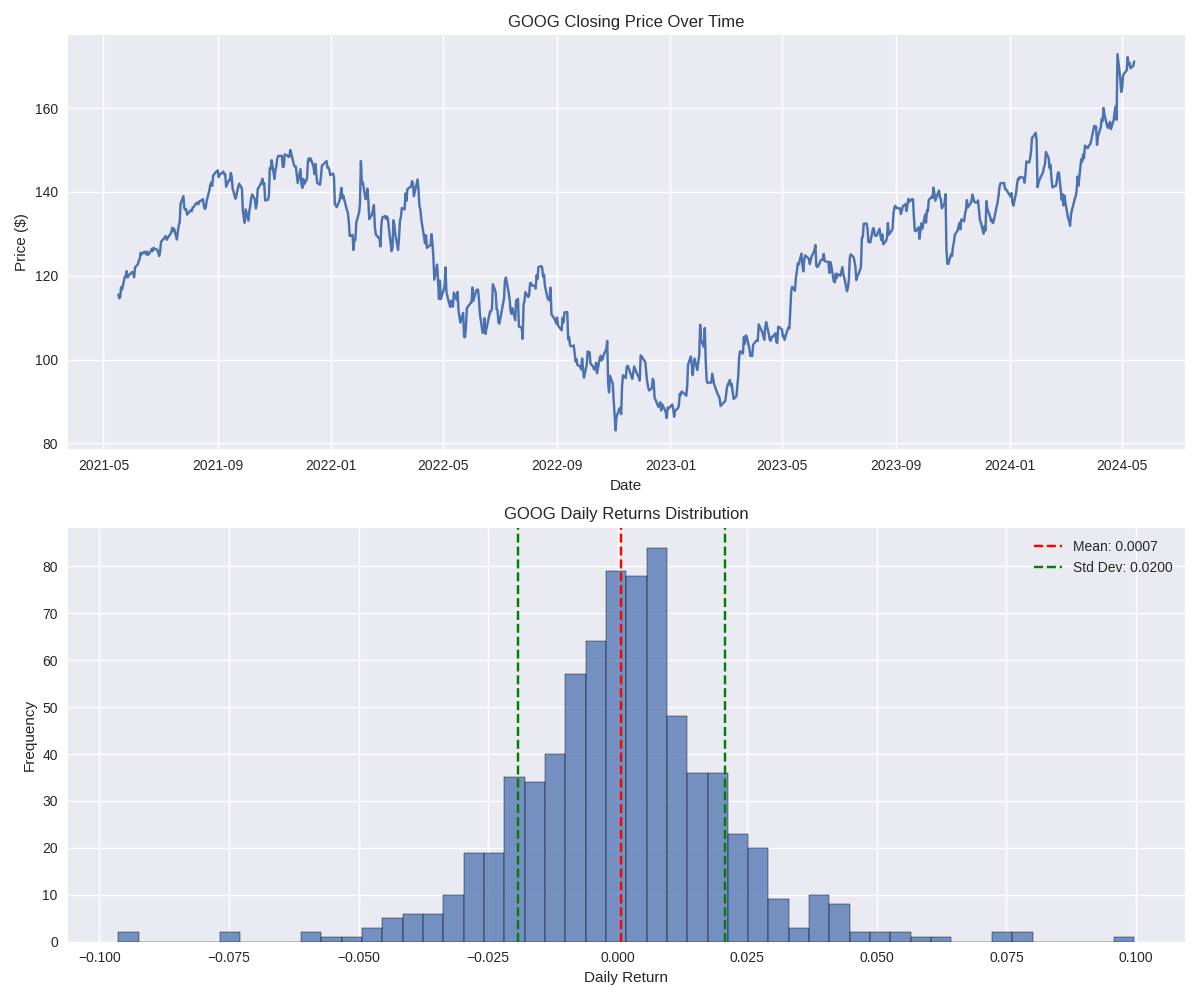

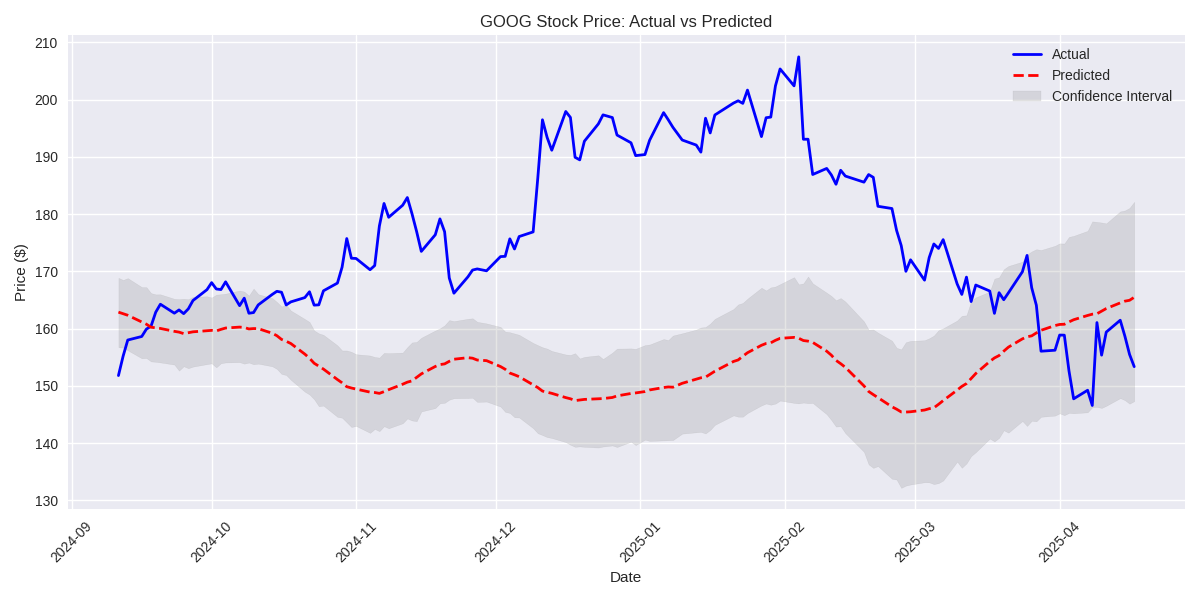

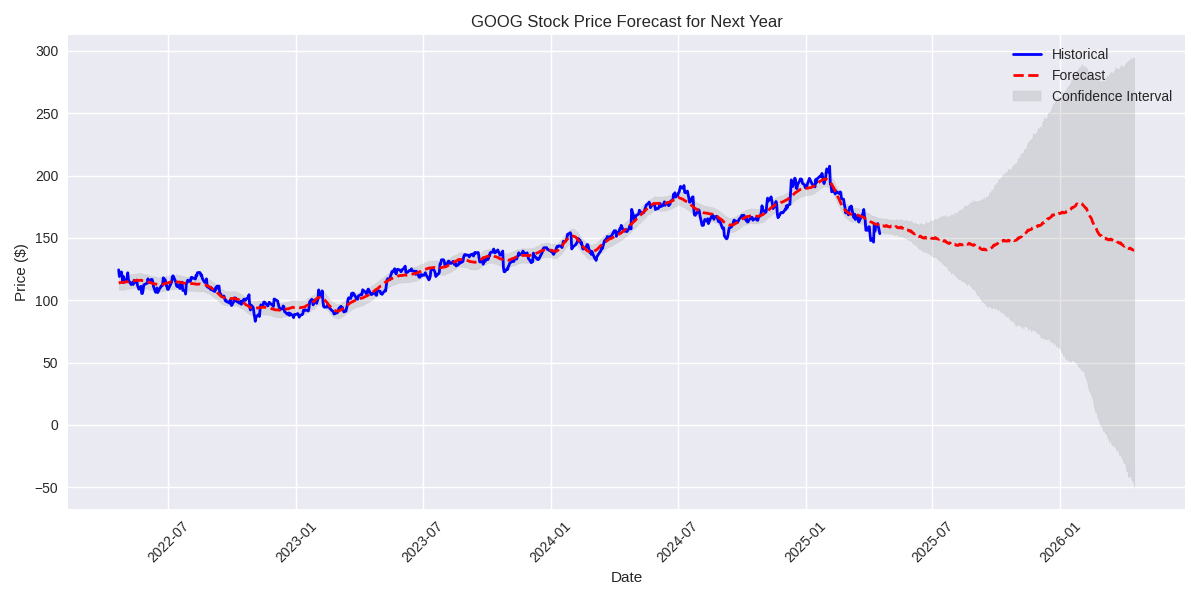

In [36]:
# Display saved png images from above agent steps
from IPython.display import Image, display

# Historical image
image_path = "GOOG_historical.png"  
display(Image(filename=image_path))

# holdout model image
display(Image(filename="GOOG_holdout_forecast.png"))

# hyperopt forecast image
display(Image(filename="GOOG_hyperopt_forecast.png"))
